In [1]:
from Models import CopyCatModel

import numpy as np
import PIL, PIL.Image
import h5py

Using TensorFlow backend.


In [2]:
# reload modules in case I change them
%load_ext autoreload
%autoreload 2

In [3]:
num_fonts = 56443
num_chars = 62

In [4]:
model = CopyCatModel(num_fonts, num_chars)
model.model.load_weights('./Weights/original.h5')

In [5]:
file = h5py.File('./Data/fonts.hdf5', 'r')
fonts = file['fonts']

In [151]:
def show_font(data):
    data = data.reshape(-1, 64, 64)
    n = data.shape[0]
    img = PIL.Image.new('L', (8 * 64, 8 * 64), 255)
    for z in range(n):
        x, y = z % 8, z // 8
        img_char = PIL.Image.fromarray(np.uint8((1 - data[z]) * 255))
        img.paste(img_char, (x * 64, y * 64))
    return img

In [138]:
def show_real_font(font):
    data = fonts[font]
    n = data.shape[0]
    img = PIL.Image.new('L', (8 * 64, 8 * 64), 255)
    for z in range(n):
        x, y = z % 8, z // 8
        img_char = PIL.Image.fromarray(np.uint8(((255 - data[z]))))
        img.paste(img_char, (x * 64, y * 64))
    return img

In [133]:
def show_predicted_font(font):
    char = np.zeros((num_chars, num_chars))
    char[np.arange(num_chars), np.arange(num_chars)] = 1
    fonts_ohe = np.zeros((num_chars, num_fonts))
    fonts_ohe[:, font] = 1
    data = model.model.predict([fonts_ohe, char]).reshape(-1, 64, 64)
    n = data.shape[0]

    img = PIL.Image.new('L', (8 * 64, 8 * 64), 255)
    for z in range(n):
        x, y = z % 8, z // 8
        img_char = PIL.Image.fromarray(np.uint8((1 - data[z]) * 255))
        img.paste(img_char, (x * 64, y * 64))
    return img

In [134]:
def show_char(font, char):
    char_ohe = np.zeros((1, num_chars))
    fonts_ohe = np.zeros((1, num_fonts))
    char_ohe[0, char] = 1
    fonts_ohe[0, font] = 1
    predicted = model.model.predict([fonts_ohe, char_ohe]).reshape(64, 64)
    predicted = PIL.Image.fromarray(np.uint8(((1 - predicted) * 255)))
    real = fonts[font][char]
    real = PIL.Image.fromarray(np.uint8(255 - real))
    img = PIL.Image.new('L', (2 * 64, 1 * 64), 255)
    img.paste(real, (0 * 64, 0 * 64))
    img.paste(predicted, (1 * 64, 0 * 64))
    return img

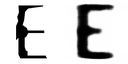

In [135]:
show_char(160, 4)

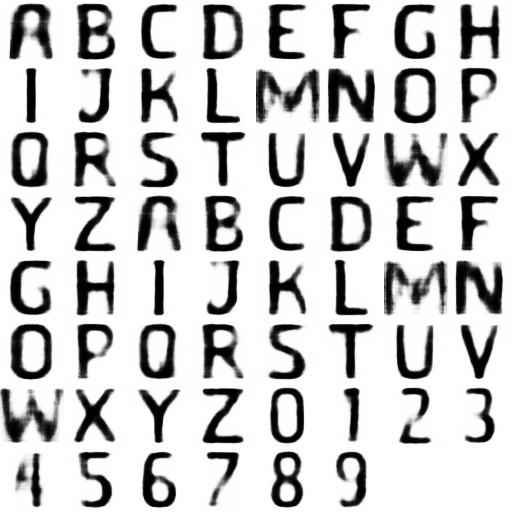

In [137]:
show_predicted_font(160)

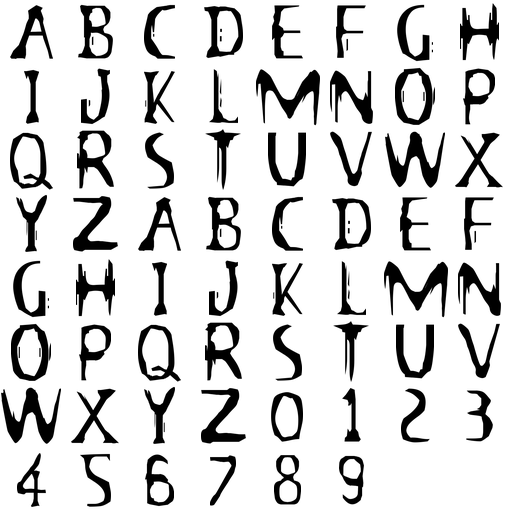

In [139]:
show_real_font(160)

In [175]:
class InterpolateFonts():
    def __init__(self, start_font, end_font):
        self.char_ohe = np.zeros((num_chars, num_chars))
        self.char_ohe[np.arange(num_chars), np.arange(num_chars)] = 1

        self.fonts_ohe_1 = np.zeros((num_chars, num_fonts))
        self.fonts_ohe_1[:, start_font] = 1

        self.embedding1 = model.encoder.predict([self.fonts_ohe_1])

        self.fonts_ohe_2 = np.zeros((num_chars, num_fonts))
        self.fonts_ohe_2[:, end_font] = 1

        self.embedding2 = model.encoder.predict([self.fonts_ohe_2])
    
    def interpolate(self, alpha=0.5):
        self.embedding = (1 - alpha) * self.embedding1 + alpha * self.embedding2
        output = model.decoder.predict([self.embedding, self.char_ohe])
        return show_font(output)
    
    def add(self, w):
        self.embedding = self.embedding1 + w * self.embedding2
        output = model.decoder.predict([self.embedding, self.char_ohe])
        return show_font(output)


In [179]:
myfont = InterpolateFonts(180, 162)

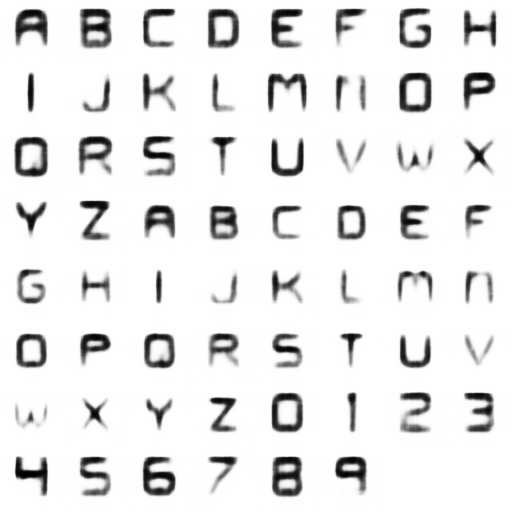

In [177]:
myfont.interpolate()

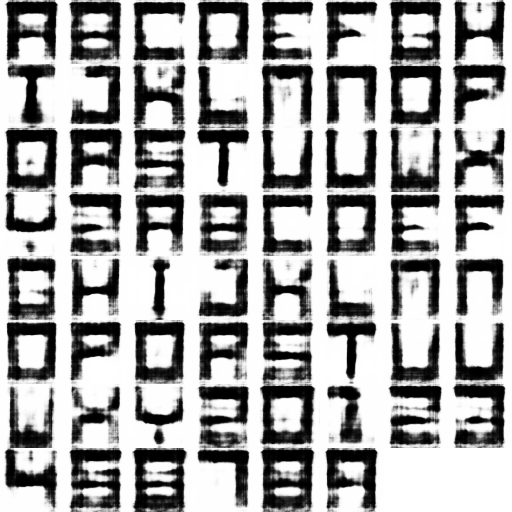

In [186]:
myfont.add(1.9)    